In [ ]:
#Mounting on co-lab
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,'/content/drive/My Drive/XD2_Net_BPIC_2012') # change folder name


Mounted at /content/drive


### Setup of the Environment

In [ ]:
#!pip install --upgrade plotly
!pip install -q -U keras-tuner --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.2 MB/s eta 0:00:00


In [ ]:
#Import of Libaries

import os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy.ma.core import argmax

#Data Preprocessing
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.cluster import KMeans


#Model Building and Explanations
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend, Model, callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
import keras_tuner as kt #hyperparameter tuning
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score, f1_score
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


#custom functions
from functions.data_proc import *
from functions.experiment_setup import *
from functions.generate_inputs import *
from functions.model import *


### Setting up experiment parameters

In [ ]:
#Experimental parameters
prediction = 'los' # 'disposition'
experiment =  'mimicel_2hrs'
timelapsed = 'total'


#Directories
MY_WORKSPACE_DIR = "/content/drive/My Drive/XD2Net_CaseStudy"
MILESTONE_DIR = MY_WORKSPACE_DIR+'/'+experiment+'/'+prediction+'/'

#Dataset
file_name = os.path.join(os.path.join(MY_WORKSPACE_DIR,'MIMICEL_PREPROCESSING'),'mimicel_pred.csv')
log_name = 'mimicel'


#saving parameters to a dictionary
args = get_parameters(MILESTONE_DIR, MY_WORKSPACE_DIR, prediction, experiment, file_name, log_name,None)




### Load Data

In [ ]:
#Load data

log_df = pd.read_csv(args['file_name'])
log_df = log_df.reset_index(drop=True)


In [ ]:
log_df.head()

,stay_id,timestamps,activity,activity_index,transition,loop_len_min,enter_time,discharge_time,disposition,los_min,...,medication_category,medication_method,arrival_transport,pain,acuity,chiefcomplaint,chiefcomplaint_category,chiefcomplaint_flag,hour,patient_count
0,30000012,2126-02-14 20:22:00,Enter the ED,0.0,NaN,NaN,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN,2126-02-14 20:00:00,6
1,30000012,2126-02-14 20:22:01,Triage in the ED,1.0,Enter the ED->Triage in the ED,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN,2126-02-14 20:00:00,6
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,2.0,Triage in the ED->Medicine reconciliation,119.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN,2126-02-14 22:00:00,6
3,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN,2126-02-14 22:00:00,6
4,30000012,2126-02-14 22:21:00,Medicine reconciliation,4.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN,2126-02-14 22:00:00,6


In [ ]:
log_df.isna().sum()

stay_id                          0
timestamps                       0
activity                         0
activity_index                   0
transition                  425028
loop_len_min                425028
enter_time                       0
discharge_time                   0
disposition                      0
los_min                          0
time_elapsed_min                 0
temperature                 425028
heartrate                   425028
resprate                    425028
o2sat                       425028
sbp                         425028
dbp                         425028
temperature_diff            850056
heartrate_diff              850056
resprate_diff               850056
o2sat_diff                  850056
sbp_diff                    850056
dbp_diff                    850056
temperature_ref_diff        425028
heartrate_ref_diff          425028
resprate_ref_diff           425028
o2sat_ref_diff              425028
sbp_ref_diff                425028
dbp_ref_diff        

In [ ]:
#replacing nan values

#acuity: replace with 3, #chiefcomplaint_flag: replace with 'none'
log_df['acuity']= log_df['acuity'].fillna(3)
log_df['chiefcomplaint_flag']= log_df['chiefcomplaint_flag'].fillna('None')

In [ ]:
log_df.columns

Index(['stay_id', 'timestamps', 'activity', 'activity_index', 'transition',
       'loop_len_min', 'enter_time', 'discharge_time', 'disposition',
       'los_min', 'time_elapsed_min', 'temperature', 'heartrate', 'resprate',
       'o2sat', 'sbp', 'dbp', 'temperature_diff', 'heartrate_diff',
       'resprate_diff', 'o2sat_diff', 'sbp_diff', 'dbp_diff',
       'temperature_ref_diff', 'heartrate_ref_diff', 'resprate_ref_diff',
       'o2sat_ref_diff', 'sbp_ref_diff', 'dbp_ref_diff', 'medication_name',
       'medication_category', 'medication_method', 'arrival_transport', 'pain',
       'acuity', 'chiefcomplaint', 'chiefcomplaint_category',
       'chiefcomplaint_flag', 'hour', 'patient_count'],
      dtype='object')

In [ ]:
#feature categories
cat_dynamic = ['transition','medication_category','medication_method']
num_dynamic = ['loop_len_min','time_elapsed_min', 'temperature_ref_diff', 'heartrate_ref_diff',
       'resprate_ref_diff', 'o2sat_ref_diff', 'sbp_ref_diff', 'dbp_ref_diff',
       'temperature_diff', 'heartrate_diff', 'resprate_diff', 'o2sat_diff',
       'sbp_diff', 'dbp_diff','patient_count']
cat_static = ['chiefcomplaint_category', 'chiefcomplaint_flag','arrival_transport' ]
num_static = ['acuity']
activity_name = 'activity'

In [ ]:


for feat in cat_dynamic:
  log_df[feat] = log_df[feat].astype('category')
for feat in cat_static:
  log_df[feat] = log_df[feat].astype('category')


log_df.head()

,stay_id,timestamps,activity,activity_index,transition,loop_len_min,enter_time,discharge_time,disposition,los_min,...,medication_category,medication_method,arrival_transport,pain,acuity,chiefcomplaint,chiefcomplaint_category,chiefcomplaint_flag,hour,patient_count
0,30000012,2126-02-14 20:22:00,Enter the ED,0.0,NaN,NaN,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,None,2126-02-14 20:00:00,6
1,30000012,2126-02-14 20:22:01,Triage in the ED,1.0,Enter the ED->Triage in the ED,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,None,2126-02-14 20:00:00,6
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,2.0,Triage in the ED->Medicine reconciliation,119.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,None,2126-02-14 22:00:00,6
3,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,None,2126-02-14 22:00:00,6
4,30000012,2126-02-14 22:21:00,Medicine reconciliation,4.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,None,2126-02-14 22:00:00,6


In [ ]:
#establish outcome

if prediction == 'los':
  log_df['outcome'] = 'N' # N - Less than median los, Y - more than median los
  log_df.loc[log_df['los_min']>=508,'outcome'] = 'Y'
else:
  log_df['outcome'] = 'N' # N - Not Admitted, Y - Admitted
  log_df.loc[log_df['disposition']== 'ADMITTED','outcome'] = 'Y'

### Data Preprocessing

In this use case of process inspection, we are interested only at the processes which are longer than 24 hours (that is taken more than a day to process). Despite taking long (and effort), these have a very high proportion of declined loan applications, which results in waste of orgnaizational resources

In [ ]:
def split_train_test(df, percentage, caseid, activity_index):


  cases = df[caseid].nunique()
  num_test_cases = int(np.round(cases*percentage))

  prefixes = pd.DataFrame(df[ caseid].unique(),columns= [ caseid])
  prefixes = prefixes.sample(frac=1).reset_index(drop=True)

  test_cases = prefixes[:num_test_cases].reset_index(drop=True)
  test_cases['index_2'] = test_cases.index

  train_cases = prefixes[num_test_cases:].reset_index(drop=True)
  train_cases['index_2'] = train_cases.index

  df_train = train_cases.merge(df,on =  caseid)
  df_train = df_train.sort_values(['index_2', activity_index], ascending = (True, True))
  df_train = df_train.drop(['index_2'],axis = 1)

  df_test = test_cases.merge(df,on = caseid)
  df_test = df_test.sort_values(['index_2', activity_index], ascending = (True, True))
  df_test = df_test.drop(['index_2'], axis = 1)

  return df_train, df_test

In [ ]:
#selection of cases with > 2 hour case length
df_case_len = log_df.loc[log_df['activity']!= 'Discharge from the ED'].groupby('stay_id')['time_elapsed_min'].max().reset_index()
df_case_len = df_case_len.loc[df_case_len['time_elapsed_min'] >= 60*2][['stay_id']]

#filtering log df
log_df = log_df.merge(df_case_len, on = 'stay_id')



In [ ]:
#split test train
log_df_train, log_df_test =  split_train_test(log_df, 0.3, 'stay_id', 'activity_index')




In [ ]:
#generating prefixes (elimination of events occurred after 24 hours)
log_df_train = log_df_train.loc[(log_df_train['time_elapsed_min'] <=  60*2) & (log_df_train['activity']!= 'Discharge from the ED')]
log_df_test = log_df_test.loc[(log_df_test['time_elapsed_min'] <=  60*2) & (log_df_test['activity']!= 'Discharge from the ED')]


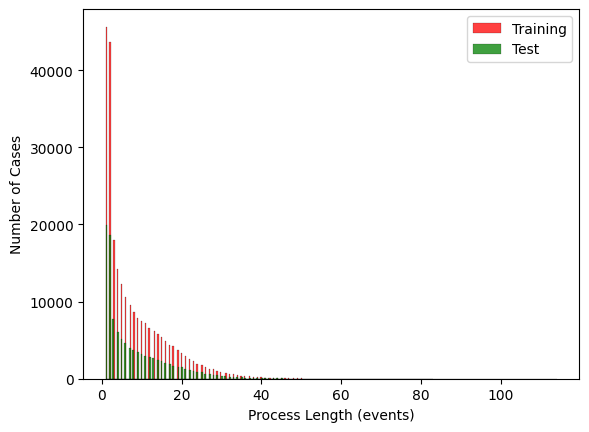

In [ ]:
#distribution of number of activities
df_t1 = log_df_train.groupby('stay_id')['activity_index'].max().reset_index()
df_t2 = log_df_test.groupby('stay_id')['activity_index'].max().reset_index()

sn.histplot(df_t1['activity_index'], kde=False, label="Training", color = 'red')
sn.histplot(df_t2['activity_index'], kde=False, label="Test", color = 'green')

# Add labels and legend
plt.xlabel("Process Length (events)")
plt.ylabel("Number of Cases")
plt.legend()
plt.show()

In [ ]:
print('training dataset')
print(log_df_train.groupby(['outcome'])['stay_id'].nunique())
print("")
print('test dataset')
print(log_df_test.groupby(['outcome'])['stay_id'].nunique())
print("")


training dataset
outcome
N    180612
Y     71493
Name: stay_id, dtype: int64

test dataset
outcome
N    77235
Y    30810
Name: stay_id, dtype: int64



In [ ]:
def balance(log_df,target,minority_label,id,activity_index):

  df_min = log_df[log_df[target] == minority_label]
  df_maj = log_df[log_df[target] != minority_label]

  fraction = df_min[id].nunique()/df_maj[id].nunique()

  cases_maj = pd.DataFrame(df_maj[id].unique(),columns= [id])
  cases_maj = cases_maj.sample(frac=fraction).reset_index(drop=True)


  df_maj = df_maj.merge(cases_maj,on = id)
  df_maj = df_maj.sort_values([id, activity_index], ascending = (True, True))

  df = pd.concat([df_min,df_maj])

  cases = pd.DataFrame(df[id].unique(),columns= [id])
  cases = cases.sample(frac=1).reset_index(drop=True)
  cases['index_1'] = cases.index

  df = cases.merge(df,on = id)
  df = df.sort_values(['index_1', activity_index], ascending = (True, True))
  df = df.drop(columns = 'index_1')


  return df

In [ ]:
#balancing the training set
log_df_train = balance(log_df_train ,'outcome','Y','stay_id','activity_index')
print('training dataset')
print(log_df_train.groupby(['outcome'])['stay_id'].nunique())
print("")
print('test dataset')
print(log_df_test.groupby(['outcome'])['stay_id'].nunique())
print("")



training dataset
outcome
N    71493
Y    71493
Name: stay_id, dtype: int64

test dataset
outcome
N    77235
Y    30810
Name: stay_id, dtype: int64



In [ ]:
#saving event log files
file_name_train_log = os.path.join(MILESTONE_DIR,log_name+'_log_df_train.csv')
log_df_train.to_csv(file_name_train_log)

file_name_test_log = os.path.join(MILESTONE_DIR,log_name+'_log_df_test.csv')
log_df_test.to_csv(file_name_test_log)


In [ ]:
#removing some of the raws that are not necessary for the process
#'Enter the ED', 'Triage in the ED', 'Medicine reconciliation-> Medicine reconciliation' loops that happened at the same time

log_df_train['drop_raws'] = 0
log_df_train.loc[(log_df_train['activity']=='Enter the ED') | (log_df_train['activity']=='Triage in the ED')| ((log_df_train['transition']=='Medicine reconciliation->Medicine reconciliation') & (log_df_train['loop_len_min']==0 )),'drop_raws']= 1
log_df_train = log_df_train.loc[log_df_train['drop_raws'] == 0]

log_df_test['drop_raws'] = 0
log_df_test.loc[(log_df_test['activity']=='Enter the ED') | (log_df_test['activity']=='Triage in the ED')| ((log_df_test['transition']=='Medicine reconciliation->Medicine reconciliation') & (log_df_test['loop_len_min']==0 )),'drop_raws']= 1
log_df_test = log_df_test.loc[log_df_test['drop_raws'] == 0]


log_df_train.head(10)

,stay_id,timestamps,activity,activity_index,transition,loop_len_min,enter_time,discharge_time,disposition,los_min,...,arrival_transport,pain,acuity,chiefcomplaint,chiefcomplaint_category,chiefcomplaint_flag,hour,patient_count,outcome,drop_raws
2,35041858,2175-06-27 18:31:00,Medicine reconciliation,2.0,Triage in the ED->Medicine reconciliation,92.0,2175-06-27 16:59:00,2175-06-27 22:37:00,HOME,338.0,...,AMBULANCE,8,3.0,ABD PAIN,Digestive,None,2175-06-27 18:00:00,11,N,0
4,35041858,2175-06-27 18:32:00,Vital sign check,4.0,Medicine reconciliation->Vital sign check,1.0,2175-06-27 16:59:00,2175-06-27 22:37:00,HOME,338.0,...,AMBULANCE,8,3.0,ABD PAIN,Digestive,None,2175-06-27 18:00:00,11,N,0
7,37492028,2190-04-01 18:10:00,Vital sign check,2.0,Triage in the ED->Vital sign check,1.0,2190-04-01 18:09:00,2190-04-01 21:46:00,ADMITTED,217.0,...,AMBULANCE,0,2.0,"Abd pain, GI bleed",Digestive,None,2190-04-01 18:00:00,6,N,0
8,37492028,2190-04-01 18:35:00,Medicine dispensations,3.0,Vital sign check->Medicine dispensations,25.0,2190-04-01 18:09:00,2190-04-01 21:46:00,ADMITTED,217.0,...,AMBULANCE,0,2.0,"Abd pain, GI bleed",Digestive,None,2190-04-01 18:00:00,6,N,0
9,37492028,2190-04-01 18:50:00,Medicine dispensations,4.0,Medicine dispensations->Medicine dispensations,15.0,2190-04-01 18:09:00,2190-04-01 21:46:00,ADMITTED,217.0,...,AMBULANCE,0,2.0,"Abd pain, GI bleed",Digestive,None,2190-04-01 18:00:00,6,N,0
10,37492028,2190-04-01 18:50:00,Medicine dispensations,5.0,Medicine dispensations->Medicine dispensations,0.0,2190-04-01 18:09:00,2190-04-01 21:46:00,ADMITTED,217.0,...,AMBULANCE,0,2.0,"Abd pain, GI bleed",Digestive,None,2190-04-01 18:00:00,6,N,0
11,37492028,2190-04-01 18:50:00,Medicine dispensations,6.0,Medicine dispensations->Medicine dispensations,0.0,2190-04-01 18:09:00,2190-04-01 21:46:00,ADMITTED,217.0,...,AMBULANCE,0,2.0,"Abd pain, GI bleed",Digestive,None,2190-04-01 18:00:00,6,N,0
12,37492028,2190-04-01 18:50:00,Medicine dispensations,7.0,Medicine dispensations->Medicine dispensations,0.0,2190-04-01 18:09:00,2190-04-01 21:46:00,ADMITTED,217.0,...,AMBULANCE,0,2.0,"Abd pain, GI bleed",Digestive,None,2190-04-01 18:00:00,6,N,0
13,37492028,2190-04-01 18:53:00,Medicine dispensations,8.0,Medicine dispensations->Medicine dispensations,3.0,2190-04-01 18:09:00,2190-04-01 21:46:00,ADMITTED,217.0,...,AMBULANCE,0,2.0,"Abd pain, GI bleed",Digestive,None,2190-04-01 18:00:00,6,N,0
14,37492028,2190-04-01 19:16:00,Medicine reconciliation,9.0,Medicine dispensations->Medicine reconciliation,23.0,2190-04-01 18:09:00,2190-04-01 21:46:00,ADMITTED,217.0,...,AMBULANCE,0,2.0,"Abd pain, GI bleed",Digestive,None,2190-04-01 19:00:00,7,N,0


In [ ]:
n = log_df_train['medication_category'].nunique()
n_meds = log_df_train['medication_category'].unique()
for i in range(n):
  print(str(i)+': '+ str(n_meds[i]))


0: None
1: Other
2: Anti-biotic
3: Nausea and vomit prevension
4: Pain reliever
5: Blood thinner
6: Fever reducer
7: Anti-psychotic
8: Anti-inflamatory
9: Antihistamin
10: Sedative
11: General anesthetic
12: Reflux reliever
13: Nerve pain reliever
14: Airflow improver
15: IBS reliever
16: Multivitamin
17: Cardio medication


### Feature encoding and vectorization

##### Support Functions

In [ ]:
def normalize_events(log_df,args,features): #updated in functions script
    """[summary]

    Args:
        log_df (DataFrame): The dataframe with eventlog data
        args (Dictionary): The set of parameters
        features (list): the list of feature name

    Returns:
        Dataframe: Returns a Dataframe with normalized numerical features
    """

    for feature in features:
        if args['norm_method'] == 'max':
            min_feature = np.min(log_df[feature])
            max_feature = np.max(log_df[feature])
            norm = lambda x: (x[feature]-min_feature)/(max_feature-min_feature)
            log_df['%s_norm'%(feature)] = log_df.apply(norm, axis=1)
        elif args['norm_method'] == 'lognorm':
            min_feature = np.min(log_df[feature])
            max_feature = np.max(log_df[feature])
            norm = lambda x: (x[feature]-min_feature)/(max_feature-min_feature)
            log_df['%s_norm'%(feature)] = log_df.apply(norm, axis=1)
            logit = lambda x: math.log1p(x['%s_norm'%(feature)])
            log_df['%s_norm'%(feature)] = log_df.apply(logit, axis=1)
    return log_df

In [ ]:
#Feature Encoding



def encode_features(log_df_train,log_df_test):

  indexes = {}
  dynamic_indexes = {}
  static_indexes = {}


  for feat in cat_dynamic:
    feat_index = create_index(log_df_train, feat,True)
    index_feat = {v: k for k, v in feat_index.items()}
    dynamic_indexes[feat+'_index'] = feat_index
    dynamic_indexes['index_'+feat] = index_feat
  indexes ['dynamic_indexes'] = dynamic_indexes

  for feat in cat_static:
    feat_index = create_index(log_df_train, feat,False)
    index_feat = {v: k for k, v in feat_index.items()}
    static_indexes[feat+'_index'] = feat_index
    static_indexes['index_'+feat] = index_feat
  indexes ['static_indexes'] = static_indexes

  oc_index = create_index(log_df_train, 'outcome',False)
  index_oc = {v: k for k, v in oc_index.items()}
  indexes['oc_index'] = oc_index
  indexes['index_oc'] = index_oc

  #mapping the dictionary values as columns in the dataframe - train set
  for feat in cat_dynamic:
    log_df_train[feat+'_index'] = log_df_train[feat].map(indexes ['dynamic_indexes'][feat+'_index'])
    log_df_test[feat+'_index'] = log_df_test[feat].map(indexes ['dynamic_indexes'][feat+'_index'])

  for feat in cat_static:
    log_df_train[feat+'_index'] = log_df_train[feat].map(indexes ['static_indexes'][feat+'_index'])
    log_df_test[feat+'_index'] = log_df_test[feat].map(indexes ['static_indexes'][feat+'_index'])

  log_df_train['oc_index'] = log_df_train['outcome'].map(indexes ['oc_index'])
  log_df_test['oc_index'] = log_df_test['outcome'].map(indexes ['oc_index'])


  #------------------------------------------------------------------------------------------------
  #Normalizing Numerical features
  numerical_features = num_dynamic.copy()
  numerical_features.extend(num_static)

  log_df_train = normalize_events(log_df_train,args,numerical_features)
  log_df_test = normalize_events(log_df_test,args,numerical_features)

  return log_df_train, log_df_test, indexes

  #vectorization (obtaining the event level feature vector)

def vectorization(log, indexes, trc_len,cases, cat_dynamic, num_dynamic,cat_static,num_static, activity_feature):
    """Example function with types documented in the docstring.
    Args:
        #log: event log data in a dictionary.
        #ac_index (dict): index of activities.
        #rl_index (dict): index of roles (departments).
        #di_index (dict) : index of diagnosis codes.

    Returns:
        vec: Dictionary that contains all the LSTM inputs. """


    vec = {'prefixes':dict(), 'prop':dict(),'statics':dict(),'outcome':[],'caseid':[]}
    len_ac = trc_len

    for i ,_ in enumerate(log):
        ac_order = log[i]['dynamic'][activity_feature]
        padding = np.full(len_ac-len(ac_order),0)

        if i == 0:

          for feat in cat_dynamic:
            vec['prefixes'][feat] = np.array(np.append(log[i]['dynamic'][feat],padding))
          for feat in num_dynamic:
            vec['prefixes'][feat] = np.array(np.append(log[i]['dynamic'][feat],padding))
          for feat in cat_static:
            vec['statics'][feat] = np.array(log[i]['static'][feat])
          for feat in num_static:
            vec['statics'][feat] = np.array(log[i]['static'][feat])

          vec['outcome'] = np.array(log[i]['outcome'])
          vec['caseid'] = np.array(log[i]['caseid'])
          vec['prop']['len'] = np.array(len(ac_order))

        else:
            for feat in cat_dynamic:
                vec['prefixes'][feat] = np.concatenate((vec['prefixes'][feat],np.array(np.append(log[i]['dynamic'][feat],padding))), axis = 0)
            for feat in num_dynamic:
                vec['prefixes'][feat] = np.concatenate((vec['prefixes'][feat],np.array(np.append(log[i]['dynamic'][feat],padding))), axis = 0)
            for feat in cat_static:
                vec['statics'][feat] = np.append(vec['statics'][feat],log[i]['static'][feat])
            for feat in num_static:
                vec['statics'][feat] = np.append(vec['statics'][feat],log[i]['static'][feat])

            vec['outcome'] = np.append(vec['outcome'],log[i]['outcome'])
            vec['caseid'] = np.append(vec['caseid'],log[i]['caseid'])
            vec['prop']['len'] = np.append(vec['prop']['len'],len(ac_order))

    #The concatenation returns a flattened vector. Hence, reshaping the vectors at the end
    for feat in cat_dynamic:
      vec['prefixes'][feat] = np.reshape(vec['prefixes'][feat],(cases,len_ac))
    for feat in num_dynamic:
      vec['prefixes'][feat] = np.reshape(vec['prefixes'][feat],(cases,len_ac))

    return vec


In [ ]:
log_df_train, log_df_test, indexes = encode_features(log_df_train, log_df_test)


In [ ]:
#Data Reformatting into a dictionary

def reformat_events(log_df, indexes, cat_dynamic, num_dynamic,cat_static,num_static,caseid,activity_index):
    """Creates series of activities, roles and relative times per trace.
    Args:
        log_df: dataframe.
        ac_index (dict): index of activities.
        rl_index (dict): index of roles.
    Returns:
        list: lists of activities, roles and relative times.
    """
    log_df = log_df.to_dict('records')

    temp_data = list()
    log_df = sorted(log_df, key=lambda x: (x[caseid], x[activity_index]))
    for key, group in itertools.groupby(log_df, key=lambda x: x[caseid]):
        trace = list(group)

        temp_dict = {}
        dynamic = {}
        static = {}

        #dynamic features
        for feat in cat_dynamic:
          cd_order = [x[feat+'_index'] for x in trace]
          cd_order.reverse()
          dynamic[feat] = cd_order

        for feat in num_dynamic:
          nd_order = [x[feat+'_norm'] for x in trace]
          nd_order.reverse()
          dynamic[feat] = nd_order

        #static features
        for feat in cat_static:
          cs = max(x[feat+'_index'] for x in trace)
          static[feat] = cs

        #static features
        for feat in num_static:
          ns = max(x[feat+'_norm'] for x in trace)
          static[feat] = ns

        #outcome
        outcome = max(x['oc_index'] for x in trace)

        temp_dict['caseid'] = key
        temp_dict['dynamic'] = dynamic
        temp_dict['static'] = static
        temp_dict['outcome'] = outcome

        temp_data.append(temp_dict)

    return temp_data

In [ ]:
#Data Reformatting into a dictionary

#Reformating the event log
log_train = reformat_events(log_df_train, indexes,cat_dynamic, num_dynamic,cat_static,num_static,'stay_id','activity_index')
log_test = reformat_events(log_df_test, indexes,cat_dynamic, num_dynamic,cat_static,num_static,'stay_id','activity_index')



In [ ]:
def vectorization(log,max_len,cat_dynamic, num_dynamic,cat_static,num_static,activity_name):


  vec = {'prefixes':dict(), 'prop':dict(),'statics':dict(),'outcome':[],'caseid':[]}
  vec['prop']['len'] = []
  for feat in cat_dynamic:
    vec['prefixes'][feat] = np.zeros((len(log), max_len))
  for feat in cat_static:
    vec['statics'][feat] = np.zeros(len(log))
  for feat in num_dynamic:
    vec['prefixes'][feat] = np.zeros((len(log), max_len))
  for feat in num_static:
    vec['statics'][feat] = np.zeros(len(log))

  for i in range(len(log)):

    trc_len =len(log[i]['dynamic'][activity_name])
    pad_len = max_len-trc_len

    if pad_len <0:
      pad_len =0

    for feat in cat_dynamic:
      vec['prefixes'][feat][i,:] = np.pad(log[i]['dynamic'][feat],(0,pad_len),mode='constant')[:max_len]

    for feat in num_dynamic:
      vec['prefixes'][feat][i,:] = np.pad(log[i]['dynamic'][feat],(0,pad_len),mode='constant')[:max_len]


    for feat in cat_static:
      vec['statics'][feat][i] = log[i]['static'][feat]

    for feat in num_static:
      vec['statics'][feat][i] = log[i]['static'][feat]


    vec['outcome'] =np.append(vec['outcome'],log[i]['outcome'])
    vec['caseid'] =np.append(vec['caseid'],log[i]['caseid'])
    vec['prop']['len'] = np.append(vec['prop']['len'],int(trc_len))


  return vec




##### Vectorization and Saving Processed Vectors

In [ ]:
#Obtain the maximum trc_len and cases for each set
trc_len_train, cases_train = lengths(log_train,'transition')
trc_len_test, cases_test = lengths(log_test,'transition')

max_len = max([trc_len_train,trc_len_test])
print("trace_length: "+str(max_len)+", training cases: "+str(cases_train)+", test cases: "+str(cases_test) )

vec = {}

#Converting the log into a 3D Tensor
vec_train = vectorization(log_train,max_len,cat_dynamic, num_dynamic,cat_static,num_static,'transition')
vec_test = vectorization(log_test,max_len,cat_dynamic, num_dynamic,cat_static,num_static,'transition')

vec['vec_train'] = vec_train
vec['vec_test'] = vec_test

vec

trace_length: 56, training cases: 116676, test cases: 88164


{'vec_train': {'prefixes': {'transition': array([[ 6.,  5.,  8., ...,  0.,  0.,  0.],
          [ 1.,  1.,  1., ...,  0.,  0.,  0.],
          [ 3.,  1.,  1., ...,  0.,  0.,  0.],
          ...,
          [10., 12., 12., ...,  0.,  0.,  0.],
          [ 5.,  8.,  0., ...,  0.,  0.,  0.],
          [ 9.,  0.,  0., ...,  0.,  0.,  0.]]),
   'medication_category': array([[14., 14., 14., ...,  0.,  0.,  0.],
          [18., 18., 18., ...,  0.,  0.,  0.],
          [14., 15., 15., ...,  0.,  0.,  0.],
          ...,
          [16., 14., 14., ...,  0.,  0.,  0.],
          [14., 14.,  0., ...,  0.,  0.,  0.],
          [14.,  0.,  0., ...,  0.,  0.,  0.]]),
   'medication_method': array([[3., 3., 3., ..., 0., 0., 0.],
          [5., 5., 5., ..., 0., 0., 0.],
          [3., 5., 5., ..., 0., 0., 0.],
          ...,
          [5., 3., 3., ..., 0., 0., 0.],
          [3., 3., 0., ..., 0., 0., 0.],
          [3., 0., 0., ..., 0., 0., 0.]]),
   'loop_len_min': array([[0.42744401, 0.0082988 , 0.139

In [ ]:
vec['vec_train']['prop']['len'].dtype

dtype('float64')

In [ ]:
#Save the vectors
# saving the processed tensor
vec_file = os.path.join(MILESTONE_DIR,'vec.p')
with open(vec_file, 'wb') as fp:
    pickle.dump(vec, fp, protocol=pickle.HIGHEST_PROTOCOL)

# saving indexes
index_file = os.path.join(MILESTONE_DIR,'index.p')
with open(index_file, 'wb') as fp:
    pickle.dump(indexes, fp, protocol=pickle.HIGHEST_PROTOCOL)

#saving the arguements (args)
args_file = os.path.join(MILESTONE_DIR,'args.p')
with open(args_file, 'wb') as fp:
    pickle.dump(args, fp, protocol=pickle.HIGHEST_PROTOCOL)


### Generating Case Level and Event Level Inputs

##### Loading Saved Vectors



In [ ]:
original_folder = MILESTONE_DIR


vec_file = os.path.join(original_folder,'vec.p')
with open(vec_file, 'rb') as fp:
    vec = pickle.load(fp)

index_file = os.path.join(original_folder,'index.p')
with open(index_file, 'rb') as fp:
    indexes = pickle.load(fp)

In [ ]:
#feature categories
cat_dynamic = ['transition','medication_category','medication_method']
num_dynamic = ['loop_len_min','time_elapsed_min', 'temperature_ref_diff', 'heartrate_ref_diff',
       'resprate_ref_diff', 'o2sat_ref_diff', 'sbp_ref_diff', 'dbp_ref_diff',
       'temperature_diff', 'heartrate_diff', 'resprate_diff', 'o2sat_diff',
       'sbp_diff', 'dbp_diff','patient_count']
cat_static = ['chiefcomplaint_category', 'chiefcomplaint_flag','arrival_transport' ]
num_static = ['acuity']
activity_name = 'activity'

In [ ]:
vec_train = vec['vec_train']
vec_test = vec['vec_test']

In [ ]:
indexes['static_indexes']

{'chiefcomplaint_category_index': {'Blood and Immune': 0,
  'Cardiovascular': 1,
  'Digestive': 2,
  'Endocrine': 3,
  'Eye/Ear/Skin': 4,
  'General and Unspecified': 5,
  'Genital': 6,
  'Musculoskeletal': 7,
  'Neurological': 8,
  'Other': 9,
  'Preganancy related': 10,
  'Psychological': 11,
  'Respiratory': 12,
  'Urologic': 13},
 'index_chiefcomplaint_category': {0: 'Blood and Immune',
  1: 'Cardiovascular',
  2: 'Digestive',
  3: 'Endocrine',
  4: 'Eye/Ear/Skin',
  5: 'General and Unspecified',
  6: 'Genital',
  7: 'Musculoskeletal',
  8: 'Neurological',
  9: 'Other',
  10: 'Preganancy related',
  11: 'Psychological',
  12: 'Respiratory',
  13: 'Urologic'},
 'chiefcomplaint_flag_index': {'Assault': 0,
  'Assault,Substance presence': 1,
  'Assault,Substance presence,Transfer': 2,
  'Assault,Transfer': 3,
  'Motor vehicle Collision': 4,
  'Motor vehicle Collision,Assault': 5,
  'Motor vehicle Collision,Substance presence': 6,
  'Motor vehicle Collision,Substance presence,Transfer':

##### Support Functions

In [ ]:
from tables.table import NoSuchNodeError

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inputs_train = {}
inputs_test = {}


#Generating Training inputs

#Event-level input and aggregated input

def get_event_ag_inputs (vec, max_len, indexes,cat_dynamic,num_dynamic):

  for i,feat in enumerate(cat_dynamic):

    feat_index = indexes['dynamic_indexes'][feat+'_index']
    feat_ohe = to_categorical(vec['prefixes'][feat][:,:max_len], num_classes=len(feat_index)) #change

    if feat_ohe.ndim <3:
      feat_ohe =  np.reshape(feat_ohe, (feat_ohe.shape[0],1,feat_ohe.shape[1]))
    if i == 0:
      event_input = feat_ohe
    else:
      event_input = np.concatenate((event_input,feat_ohe),axis=2)

  '''#replacing the raw input values for masking
  for j,prefix_len in enumerate(vec['prop']['len']):
    event_input[j][prefix_len:,:] = 0'''



  #incorporation of numerical dynamic inputs
  for i,feat in enumerate(num_dynamic):
    feat_input = vec['prefixes'][feat][:,:max_len] #change
    feat_input = np.reshape(feat_input, feat_input.shape + (1,))

    if i == 0:
      event_input_num = feat_input
    else:
      event_input_num = np.concatenate((event_input_num,feat_input),axis=2)

  event_input = np.concatenate((event_input,event_input_num),axis=2)

  event_level_names = []

  for i,feat in enumerate(cat_dynamic):
    feat_index = indexes['dynamic_indexes'][feat+'_index']
    feat_names =  [item[0] for item in feat_index.items()]
    event_level_names = np.concatenate((event_level_names,feat_names), axis = 0)

  event_level_names = np.concatenate((event_level_names,num_dynamic), axis = 0)
  event_level_names = [item for  j in range( max_len) for item in event_level_names ]


  return event_input, event_level_names




def get_static_inputs(vec, indexes,cat_static,num_static):

  input_static = []

  for i,feat in enumerate(cat_static):
    feat_index = indexes['static_indexes'][feat+'_index']
    non_val = 'UNKNOWN'
    if feat == 'chiefcomplaint_category':
      non_val = 'Other'
    elif feat == 'chiefcomplaint_flag':
      non_val = 'None'

    feat_vec = np.where(np.isnan(vec['statics'][feat]), feat_index[non_val], vec['statics'][feat])
    feat_ohe = to_categorical(feat_vec, num_classes=len(feat_index))
    if i == 0:
      input_static = feat_ohe
    else:
      input_static = np.concatenate((input_static,feat_ohe),axis = 1)

  for i,feat in enumerate(num_static):
    feat_input = vec['statics'][feat]
    feat_input = np.reshape(feat_input, feat_input.shape + (1,))
    if len(input_static) == 0:
      input_static = feat_input
    else:
      input_static = np.concatenate((input_static,feat_input),axis = 1)

  #static feature names
  static_names = []

  for i,feat in enumerate(cat_static):
    feat_index = indexes['static_indexes'][feat+'_index']
    feat_names =  [feat+'_'+item[0] for item in feat_index.items()]
    static_names = np.concatenate((static_names,feat_names), axis = 0)

  static_names = np.concatenate((static_names,num_static), axis = 0)

  return input_static,static_names



#support aggregation functions for dynamic variables

#categorical features
#get the last value of the process prefix, excluding a specified invalid value. default value has been set to 'none'
def get_last_val(vec, indexes,feat_name, max_len,None_val = 'none'):
  cases = vec['prefixes'][feat_name].shape[0]
  arr = vec['prefixes'][feat_name][:,:max_len]
  invalid_val = indexes['dynamic_indexes'][feat_name+'_index'][None_val]

  feat_arr = np.zeros(cases)
  for i in range(cases):
    feat_arr[i] = next((item for item in arr[i] if item != invalid_val), 0)

  return feat_arr

#get the most frequently occurring value of the process prefix, excluding a specified invalid value. default value has been set to 'none'
def get_mode_val(vec, indexes,feat_name, max_len, None_val = 'none'):
  cases = vec['prefixes'][feat_name].shape[0]
  arr = vec['prefixes'][feat_name][:,:max_len]
  invalid_val = indexes['dynamic_indexes'][feat_name+'_index'][None_val]

  feat_arr = np.zeros(cases)
  for i in range(cases):
    filtered_arr = arr[i][~np.isin( arr[i],[0])]
    bins = np.bincount(filtered_arr.astype(int))
    feat_arr[i] = np.argmax(bins)

  return feat_arr

#numerical features
#get the aggregated value of a numerical prefix excluding zeros

def get_non_zero_agg(vec,feat_name, max_len,agg_func = 'last'):

  arr = vec['prefixes'][feat_name][:,:max_len]
  non_zero_arr = np.where(arr != 0, arr, np.nan)

  if agg_func == 'mean':
    feat_arr =  np.nanmean(non_zero_arr, axis=1)
  elif agg_func == 'max':
    feat_arr =  np.nanmax(non_zero_arr, axis=1)
  elif agg_func == 'min':
    feat_arr =  np.nanmin(non_zero_arr, axis=1)
  else:
    feat_arr= arr[:,0]

  return feat_arr



def get_case_level_input(vec, max_len, indexes,cat_dynamic,num_dynamic):



  #aggregated feature names
  case_level_names = []
  case_input = []

  #aggregated categorical input

  #item 1 - frequency of selected dynamic inputs:
  frq_feats = ['transition']
  for i,feat in enumerate(frq_feats):

    feat_index = indexes['dynamic_indexes'][feat+'_index']
    feat_ohe = to_categorical(vec['prefixes'][feat][:,:max_len], num_classes=len(feat_index))

    if i ==0:
      case_input = np.sum(feat_ohe,axis = 1)[:,1:]
    else:
      case_input = np.concatenate((case_input,np.sum(feat_ohe,axis = 1)[:,1:]),axis = 1 )

    feat_names =  ['# of_'+feat+': '+item[0] for item in feat_index.items()][1:]
    case_level_names = np.concatenate((case_level_names,feat_names), axis = 0)



  #item 2 - last value of selected dynamic inputs
  last_feats = ['medication_category', 'medication_method']

  for i,feat in enumerate(last_feats):
    feat_index = indexes['dynamic_indexes'][feat+'_index']
    feat_arr = get_last_val(vec, indexes,feat, max_len,None_val = 'None')
    feat_ohe = to_categorical(feat_arr, num_classes=len(feat_index))


    case_input = np.concatenate((case_input,feat_ohe[:,1:]),axis = 1 )

    feat_names =  ['last_'+feat+': '+item[0] for item in feat_index.items()][1:]
    case_level_names = np.concatenate((case_level_names,feat_names), axis = 0)


  #item 3 - most frequent value of selected dynamic inputs
  mode_feats = ['medication_category']

  for i,feat in enumerate(mode_feats):
    feat_index = indexes['dynamic_indexes'][feat+'_index']
    feat_arr = get_last_val(vec, indexes,feat, max_len,None_val = 'None')
    feat_ohe = to_categorical(feat_arr, num_classes=len(feat_index))

    case_input = np.concatenate((case_input,feat_ohe[:,1:]),axis = 1 )

    feat_names =  ['most frequent_'+feat+': '+item[0] for item in feat_index.items()][1:]
    case_level_names = np.concatenate((case_level_names,feat_names), axis = 0)


  #aggregated numerical input (by different aggregate functions)
  for i,feat in enumerate(num_dynamic):


    #mean aggregated
    feat_num_mean = get_non_zero_agg(vec,feat, max_len,agg_func = 'mean')
    feat_num_mean = np.where(np.isnan(feat_num_mean), 0,feat_num_mean)
    feat_num_mean = np.reshape(feat_num_mean,feat_num_mean.shape+(1,))
    case_input = np.concatenate((case_input,feat_num_mean),axis = 1 )

    case_level_names = np.append(case_level_names,'Avg: '+feat)

    #maximum aggregated
    feat_num_max = get_non_zero_agg(vec,feat, max_len,agg_func = 'max')
    feat_num_max = np.where(np.isnan(feat_num_max), 0,feat_num_max)
    feat_num_max = np.reshape(feat_num_max,feat_num_max.shape+(1,))
    case_input = np.concatenate((case_input,feat_num_max),axis = 1 )

    case_level_names = np.append(case_level_names,'max: '+feat)

    #Last event aggregated
    feat_num_last = get_non_zero_agg(vec,feat, max_len,agg_func = 'last')
    feat_num_last = np.where(np.isnan(feat_num_last), 0,feat_num_last)
    feat_num_last = np.reshape(feat_num_last,feat_num_last.shape+(1,))
    case_input = np.concatenate((case_input,feat_num_last),axis = 1 )

    case_level_names = np.append(case_level_names,'Last '+feat)

  return case_input, case_level_names






##### Input generation




In [ ]:
inputs = {'inputs_train':{}, 'inputs_test':{}, 'names':{}}

max_len = 10

#trc_clusters_train, trc_clusters_test, best_clusters = get_trace_clusters(vec_train, vec_test, indexes)

#training inputs
event_input_train, event_level_names_train = get_event_ag_inputs(vec_train, max_len, indexes,cat_dynamic,num_dynamic)
static_input_train, static_names_train = get_static_inputs(vec_train, indexes,cat_static,num_static)
case_input_train, case_level_names_train = get_case_level_input(vec_train, max_len, indexes,cat_dynamic,num_dynamic)

case_input_train = np.concatenate((case_input_train,static_input_train), axis = 1)
case_level_names_train = np.concatenate((case_level_names_train,static_names_train), axis = 0)

#test inputs
event_input_test, event_level_names_test = get_event_ag_inputs(vec_test, max_len, indexes,cat_dynamic,num_dynamic)
static_input_test, static_names_test = get_static_inputs(vec_test, indexes,cat_static,num_static)
case_input_test, case_level_names_test = get_case_level_input(vec_test, max_len, indexes,cat_dynamic,num_dynamic)

case_input_test = np.concatenate((case_input_test,static_input_test), axis = 1)
case_level_names_test = np.concatenate((case_level_names_test,static_names_test), axis = 0)



inputs['inputs_train']['case_level'] = case_input_train
inputs['inputs_train']['event_level'] = event_input_train
inputs['inputs_train']['static'] = static_input_train

inputs['inputs_test']['case_level'] = case_input_test
inputs['inputs_test']['event_level'] = event_input_test
inputs['inputs_test']['static'] = static_input_test

inputs['names']['case_level'] = case_level_names_train
inputs['names']['event_level'] = event_level_names_train





<ipython-input-125-c7e2c6a8baa5>:141: RuntimeWarning: Mean of empty slice
  feat_arr =  np.nanmean(non_zero_arr, axis=1)
<ipython-input-125-c7e2c6a8baa5>:143: RuntimeWarning: All-NaN slice encountered
  feat_arr =  np.nanmax(non_zero_arr, axis=1)


##### Saving Processed Data and Parameters

In [ ]:


#saving the inputs generated
input_file = os.path.join(MILESTONE_DIR,'inputs.pkl')
with open(input_file, 'wb') as fp:
    pickle.dump(inputs, fp, protocol=pickle.HIGHEST_PROTOCOL)







### Retrieving Saved Inputs and Outputs

##### Retrieving Saved Data and Parameters

In [ ]:
original_folder = MILESTONE_DIR #= MY_WORKSPACE_DIR+'/60_hrs/'


vec_file = os.path.join(original_folder,'vec.p')
with open(vec_file, 'rb') as fp:
    vec = pickle.load(fp)

index_file = os.path.join(original_folder,'index.p')
with open(index_file, 'rb') as fp:
    indexes = pickle.load(fp)

input_file = os.path.join(original_folder,'inputs.pkl')
with open(input_file, 'rb') as fp:
    inputs = pickle.load(fp)

file_name_train_log = os.path.join(original_folder,log_name+'_log_df_train.csv')
log_df_train = pd.read_csv(file_name_train_log)

file_name_test_log = os.path.join(original_folder,log_name+'_log_df_test.csv')
log_df_test = pd.read_csv(file_name_test_log)

##### Generating Outputs

In [ ]:
outputs = {}
outputs['output_train'] = vec['vec_train']['outcome']
outputs['output_test'] = vec['vec_test']['outcome']

cases = {}
cases['cases_train'] = vec['vec_train']['caseid']
cases['cases_test'] = vec['vec_test']['caseid']

### Model Building And Explaining


###### XD2_Net Model

In [ ]:
#Final Self Explaining Model

def xd2_net_model_build (max_len, inputs_train ,lstm_size_alpha, lstm_size_beta, dense_1_dim, learning_rate,opt = None ):

  MAX_LEN = max_len

  incl_time = True
  incl_res = True

  dropout = 0.15
  #lstm_size_alpha =  hp.Int('units', min_value=32, max_value=512, step=32) #50
  l2reg=0.0001
  dropout_input = 0.15
  dropout_context=0.15

  dim_event_level = inputs_train['event_level'].shape[2]
  dim_case_level = inputs_train['case_level'].shape[1]
  dim_static = inputs_train['static'].shape[1]

  #configuring the inputs

  event_input = layers.Input(shape=(MAX_LEN,dim_event_level, ), name='event_input')
  static_input = layers.Input(shape = (dim_static,), name = 'static_input' )
  case_input = layers.Input(shape=(dim_case_level, ), name='exp_input')


  #LSTM layer with attention to process x

  alpha = layers.Bidirectional(layers.LSTM(lstm_size_alpha, return_sequences=True),
                                        name='alpha')
  alpha_dense = layers.Dense(1, kernel_regularizer=l2(l2reg))
  alpha_out = alpha(event_input)
  alpha_out = layers.TimeDistributed(alpha_dense, name='alpha_dense')(alpha_out)
  alpha_out = layers.Softmax(name='timestep_attention', axis=1)(alpha_out)


  #second LSTM layer with attention to process x - sequential


  beta = layers.Bidirectional(layers.LSTM(lstm_size_beta, return_sequences=True),
                                        name='beta')
  beta_dense = layers.Dense(dim_event_level,activation='tanh',kernel_regularizer=l2(l2reg))
  beta_out = beta(event_input)
  beta_out = layers.TimeDistributed(beta_dense, name='beta_dense')(beta_out)
  beta_out = layers.Softmax(name='feature_attention', axis=1)(beta_out)



  #Compute context vector based on attentions and raw input x
  c_t = layers.Multiply()([alpha_out, beta_out, event_input])
  c_t = layers.Lambda(lambda x: backend.sum(x, axis=1))(c_t)
  c_t = layers.concatenate([c_t,static_input],name = 'full_features')

  #contexts = layers.Dropout(dropout)(c_t)

  #Intermediate dense layer
  dense_1_dim = round(dim_case_level*dense_1_dim)

  dense_1 = layers.Dense(dense_1_dim,
                        activation='softmax',
                        kernel_initializer='glorot_uniform',
                        name='dense_1')(c_t)

  #Dense layer to compute the explainable weights thetas

  thetas = layers.Dense(dim_case_level,
                        activation='softmax',
                        kernel_initializer='glorot_uniform',
                        name='explanation_weights')(dense_1)
  #Regression layer

  reg = layers.Multiply(name = 'regression_input')([thetas, case_input])
  #x = layers.Lambda(lambda x: backend.sum(x, axis=1))(reg)
  #reg = layers.Dropout(dropout)(reg)

  #outcome_dim = vec['outcome'].shape[1]

  #Final Output
  #act_output = tf.math.sigmoid(x, name='act_output')

  #initialize all the weights to one
  initializer = tf.keras.initializers.Ones()
  act_output = layers.Dense(1,activation='sigmoid',kernel_initializer=initializer,trainable=True, name='act_output')(reg)


  model = Model(inputs=[event_input, static_input, case_input], outputs=act_output)

  plot_model(
        model,
        to_file="XD2_net.png",
        show_shapes=False,
        show_dtype=False,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=False,
        dpi=96,
    )
  #learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  #optimizer choice
#'Adam','Nadam','Adamax','Adagrad','RMSprop'
  if opt == 'Adam':
    optim = keras.optimizers.Adam(learning_rate=learning_rate)
  elif opt == 'Nadam':
    optim = keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
  elif opt == 'Adamax':
    optim = keras.optimizers.Adamax(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
  elif opt == 'Adagrad':
    optim = keras.optimizers.Adagrad(learning_rate=learning_rate, initial_accumulator_value=0.1, epsilon=1e-07)
  elif opt == 'RMSprop':
    optim = keras.optimizers.RMSprop(learning_rate=learning_rate)
  else:
     optim = keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(loss={'act_output': 'binary_crossentropy'}, optimizer= optim , metrics=['accuracy'])

  return model


##### Model Training

In [ ]:
def xd2_net_fit(max_len,input_train,output_train, xd2_net_model, MILESTONE_DIR, batch_size, epochs):


  early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)

  output_file_path = os.path.join(os.path.join(MILESTONE_DIR,
                                        'models'),'model'+
                                        '_{epoch:02d}-{val_loss:.2f}.h5')

  lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                    factor=0.5,
                                    patience=10,
                                    verbose=0,
                                    mode='auto',
                                    min_delta=0.0001,
                                    cooldown=0,
                                    min_lr=0)





  model_history = xd2_net_model.fit([input_train['event_level'][:,:max_len,:],input_train['static'],input_train['case_level']],output_train,
              validation_split=0.15,
              #validation_data=(model_val_inputs, model_val_outputs),
              verbose=1,
              callbacks=[early_stopping,lr_reducer],
              batch_size=batch_size,
              epochs=epochs)

  return model_history

##### Model Hyperparameter Tuning

In [ ]:
#Hyperparameter tuning and returning the best model

def xd2_net_optimum (max_len,input_train,output_train,indexes,  opt = None):

  if opt == None:
    opt = 'Adam'

  def model_builder(hp):

    lstm_size_alpha =  hp.Int('units', min_value=10, max_value=100, step=5)
    lstm_size_beta = hp.Int('units_beta', min_value=10, max_value=100, step=5)
    dense_1_dim = hp.Choice('units_dense_1', values=[1.0, 1.25, 1.5, 1.75, 2.0])
    learning_rate = 1e-2 #hp.Choice('learning_rate', values=[1e-2, 1e-3])


    model = xd2_net_model_build (max_len, input_train ,lstm_size_alpha, lstm_size_beta, dense_1_dim, learning_rate,opt)
    return model

  objective_fn =kt.Objective("val_accuracy", direction="max")
  tuner =  kt.RandomSearch(model_builder, objective=objective_fn, max_consecutive_failed_trials =20, max_trials = 10,  directory=MY_WORKSPACE_DIR)

  tuner = kt.Hyperband(model_builder,
                     objective=objective_fn,
                     max_epochs=10,
                     factor=3,
                     directory=MY_WORKSPACE_DIR,
                     overwrite=True)

  early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)

  tuner.search([input_train['event_level'][:,:max_len,:],input_train['static'],input_train['case_level']],output_train, epochs=10, validation_split=0.2, callbacks=[early_stopping])

  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

  model = tuner.hypermodel.build(best_hps)
  print(model.summary())

  return model

##### Model Testing

In [ ]:
def xd2_net_test (max_len,input_test,output_test, cases_test, xd2_net_model):

  y_pred = xd2_net_model.predict([input_test['event_level'][:,:max_len,:],input_test['static'],input_test['case_level']])
  y_true = output_test

  #get the best threshold
  thresholds = [0.5]
  f1_best = 0

  for thresh in thresholds:
    y_pred_bin = y_pred > thresh
    f1 = f1_score(y_true, y_pred_bin, average='weighted')
    if f1_best < f1:
      f1_best = f1

  roc_auc = roc_auc_score(y_true, y_pred)

  target_names = ['N','Y']
  report = classification_report(y_true, y_pred_bin , target_names=target_names, output_dict=True)

  df_predictions = pd.DataFrame({'CASEID':cases_test,'GROUND_TRUTH':y_true.flatten(),'PREDICTION_PROBABILITY':y_pred.flatten(),'BEST_PREDICTION':y_pred_bin.flatten().astype(int)})

  return df_predictions, roc_auc, report


##### Model Explain

In [ ]:
def xd2_net_explain (max_len,input_test, output_test, cases_test, xd2_net_model, feature_names):

  #deriving the explainable model with the trained xd2-net

  xd2_net_explainable = Model(inputs=xd2_net_model.input,
              outputs=[xd2_net_model.get_layer('explanation_weights').output, xd2_net_model.get_layer('timestep_attention').output,xd2_net_model.get_layer('feature_attention').output])

  explanation_weights = xd2_net_explainable.predict([input_test['event_level'][:,:max_len,:],input_test['static'],input_test['case_level']])
  last_layer_weights = xd2_net_model.get_layer('act_output').get_weights()[0].T[0]

  #case_level explanations

  df_case_level = pd.DataFrame(columns = ['CASEID','FEATURE','FEATURE_VALUE','FEATURE_IMPORTANCE','LAST_LAYER_WEIGHTS'])

  df_case_level['CASEID'] = [caseid  for caseid in cases_test for i in range(input_test['case_level'].shape[1])]
  df_case_level['FEATURE'] = [feature for i in range(cases_test.shape[0]) for feature in feature_names['case_level'] ]
  df_case_level['FEATURE_VALUE'] = input_test['case_level'].flatten()
  df_case_level['FEATURE_IMPORTANCE'] = explanation_weights[0].flatten()
  df_case_level['LAST_LAYER_WEIGHTS'] =  [weight for i in range(cases_test.shape[0]) for weight in last_layer_weights]

  #event level explanations
  df_event_level = pd.DataFrame(columns = ['CASEID','FEATURE','FEATURE_VALUE','EVENT_ATTENTION','FEATURE_ATTENTION'])

  df_event_level['CASEID'] = [caseid  for caseid in cases_test for i in range(max_len*input_test['event_level'].shape[2])]
  df_event_level['FEATURE'] = [feature for i in range(cases_test.shape[0]) for feature in feature_names['event_level'][:max_len*input_test['event_level'].shape[2]] ]
  df_event_level['FEATURE_VALUE'] = input_test['event_level'][:,:max_len,:].flatten()
  df_event_level['EVENT_ATTENTION'] = [att for att in explanation_weights[1].flatten() for i in range(input_test['event_level'].shape[2]) ]
  df_event_level['FEATURE_ATTENTION'] = explanation_weights[2].flatten()
  df_event_level['EVENT'] = [i for k in range(cases_test.shape[0]) for i in range(max_len) for j in range(input_test['event_level'].shape[2])]

  df_event_level = df_event_level.loc[df_event_level['FEATURE_VALUE'] != 0]
  df_events = df_event_level.groupby('CASEID')['EVENT'].max().reset_index()
  df_events.columns = ['CASEID','MAX_EVENTS']
  df_event_level = df_event_level.merge(df_events, on = 'CASEID')
  df_event_level['EVENT'] = df_event_level['MAX_EVENTS']+1-df_event_level['EVENT']

  return df_case_level, df_event_level






#### Feature Selection

In [ ]:
case_level_names = inputs['names']['case_level']
case_level_names = inputs['names']['event_level']




##### Execution of the Model

In [ ]:
max_len = 10
optim = 'Adam'

hp_tuning_dir = os.path.join(MILESTONE_DIR,
                                        'hp_tuning')
batch_size = 6000
epochs = 100

xd2_net_best = xd2_net_optimum (max_len,inputs['inputs_train'],outputs['output_train'],indexes,optim)
model_history = xd2_net_fit(max_len,inputs['inputs_train'],outputs['output_train'], xd2_net_best, hp_tuning_dir, batch_size, epochs)
df_predictions, roc_auc, report = xd2_net_test (max_len,inputs['inputs_test'],outputs['output_test'], cases['cases_test'],xd2_net_best)

print(roc_auc)
print(report)


Trial 30 Complete [00h 04m 48s]
val_accuracy: 0.6307850480079651

Best val_accuracy So Far: 0.6334847211837769
Total elapsed time: 01h 01m 58s
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 event_input (InputLayer)       [(None, 10, 55)]     0           []                               
                                                                                                  
 alpha (Bidirectional)          (None, 10, 50)       16200       ['event_input[0][0]']            
                                                                                                  
 beta (Bidirectional)           (None, 10, 90)       36360       ['event_input[0][0]']            
                                                                                                  
 alpha_dense (TimeDistributed)  (None, 10, 1)   

In [ ]:

df_case_level, df_event_level = xd2_net_explain (max_len,inputs['inputs_test'],outputs['output_test'], cases['cases_test'], xd2_net_best, inputs['names'])





2756/2756 [==============================] - 11s 3ms/step


In [ ]:
xd2_net_explainable = Model(inputs=xd2_net_best.input,
              outputs=[xd2_net_best.get_layer('explanation_weights').output, xd2_net_best.get_layer('timestep_attention').output,xd2_net_best.get_layer('feature_attention').output])

explanation_weights = xd2_net_explainable.predict([inputs['inputs_test']['event_level'][:,:max_len,:],inputs['inputs_test']['static'],inputs['inputs_test']['case_level']])

2756/2756 [==============================] - 10s 3ms/step


In [ ]:
explanation_weights[1][11].round(2)

array([[0.09],
       [0.05],
       [0.04],
       [0.05],
       [0.06],
       [0.06],
       [0.06],
       [0.06],
       [0.1 ],
       [0.43]], dtype=float32)

In [ ]:
vec['vec_test']['prefixes']['transition'][11]

array([9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [ ]:
df_case_level['FEATURE_WEIGHT'] = df_case_level['FEATURE_IMPORTANCE']*df_case_level['LAST_LAYER_WEIGHTS']
df_case_level_filtered = df_case_level#.loc[df_case_level['FEATURE_VALUE']!=0]

exp_global = df_case_level_filtered.groupby('FEATURE')['FEATURE_WEIGHT'].sum().reset_index().sort_values(by='FEATURE_WEIGHT',ascending = False)
exp_global['FEATURE_WEIGHT']= exp_global['FEATURE_WEIGHT']/df_case_level['CASEID'].nunique()
exp_global

,FEATURE,FEATURE_WEIGHT
43,arrival_transport_AMBULANCE,0.488002
76,chiefcomplaint_flag_Suicide Ideation/ Self Injury,0.396989
32,Last o2sat_diff,0.396885
17,Avg: o2sat_diff,0.303091
86,last_medication_category: Anti-psychotic,0.269778
...,...,...
125,most frequent_medication_category: Anti-inflam...,-0.001748
85,last_medication_category: Anti-inflamatory,-0.002441
46,arrival_transport_UNKNOWN,-0.038892
11,# of_transition: Vital sign check->Vital sign ...,-0.054276


##### Saving the Results

In [ ]:


file_predictions = os.path.join(os.path.join(MILESTONE_DIR,
                                        'outputs'),'predictions.csv')
df_predictions.to_csv(file_predictions, index = False)

file_case_level = os.path.join(os.path.join(MILESTONE_DIR,
                                        'outputs'),'case_level_explanations.csv')
df_case_level.to_csv(file_case_level, index = False)

file_event_level = os.path.join(os.path.join(MILESTONE_DIR,
                                        'outputs'),'event_level_explanations.csv')
df_event_level.to_csv(file_event_level, index = False)